## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test2
import friedman2Dataset
import network
import dataset
import sanityChecks
import torch 
import scrapbook as sb
from statistics import mean 
import catboost as ctb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np

## Parameters 

In [3]:
variance = 1

## Dataset 


In [4]:
#Parameters 
n_features = 4
n_samples= 100
n_target = 1 

In [5]:
X,Y = friedman2Dataset.friedman2_data(n_samples)

          X1           X2        X3        X4           Y
0  20.735462   895.297982  0.335390  2.917816  300.890895
1  45.324436  1624.043306  0.131652  7.277265  218.501361
2  98.276563  1744.386725  0.202845  6.092381  367.242136
3  81.028395   462.849598  0.756686  8.607281  359.459121
4  90.403086  1301.564281  0.264299  7.421802  355.545354


In [6]:
#Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)


## Training Parameters 

In [7]:
batch_size = 32
n_epochs = 1000
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ABC Pre-generator Model 

1. The catboost model is used as a pre-generator model for the ABC-GAN. 
2. The model is first trained on the entire dataset 
3. It generats X,Y pairs and we add some Gaussian noise with mean 0 and variance 1 to it which is then feed as input to the generator.


In [8]:
#Train the Model 
prior_model = ctb.CatBoostRegressor()
prior_model.fit(X_train,Y_train)

Learning rate set to 0.024897
0:	learn: 1.0488265	total: 62.2ms	remaining: 1m 2s
1:	learn: 1.0360495	total: 63.2ms	remaining: 31.5s
2:	learn: 1.0252039	total: 63.9ms	remaining: 21.2s
3:	learn: 1.0139065	total: 64.3ms	remaining: 16s
4:	learn: 1.0008421	total: 64.6ms	remaining: 12.9s
5:	learn: 0.9894542	total: 65.2ms	remaining: 10.8s
6:	learn: 0.9753246	total: 65.7ms	remaining: 9.32s
7:	learn: 0.9630577	total: 66.1ms	remaining: 8.19s
8:	learn: 0.9520074	total: 66.6ms	remaining: 7.33s
9:	learn: 0.9369909	total: 66.9ms	remaining: 6.62s
10:	learn: 0.9269815	total: 67.2ms	remaining: 6.04s
11:	learn: 0.9127071	total: 67.6ms	remaining: 5.57s
12:	learn: 0.9012504	total: 68ms	remaining: 5.16s
13:	learn: 0.8887254	total: 68.4ms	remaining: 4.82s
14:	learn: 0.8775377	total: 68.9ms	remaining: 4.52s
15:	learn: 0.8661113	total: 69.3ms	remaining: 4.26s
16:	learn: 0.8557096	total: 69.6ms	remaining: 4.03s
17:	learn: 0.8437603	total: 70ms	remaining: 3.82s
18:	learn: 0.8358531	total: 70.4ms	remaining: 3.63

In [9]:
y_pred = prior_model.predict(X_test)
y_abc = y_pred + np.random.normal(0,variance, y_pred.shape)
mse = mean_squared_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mse)
mse = mean_squared_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mse)

mae = mean_absolute_error(y_pred,Y_test)
sb.glue("Prior Model MAE",mae)
mae = mean_absolute_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MAE",mae)

# ABC GAN Model

In [ ]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.001, betas=(0.5, 0.999))

In [ ]:
#Training the ABC_GAN 
ABC_train_test2.training_GAN(disc,gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,0,device)

In [ ]:
ABC_GAN1_metrics=ABC_train_test2.test_generator(gen,test_data,prior_model,variance,0,"1",device)
sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)

print("MSE")
print(mean(ABC_GAN1_metrics[0]))

In [ ]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# ABC - GAN Model with skip connection

In [10]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.001, betas=(0.5, 0.999))


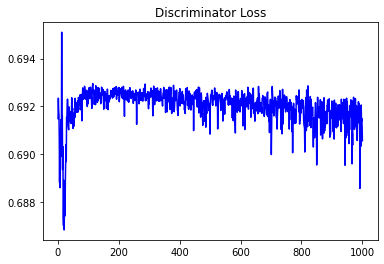

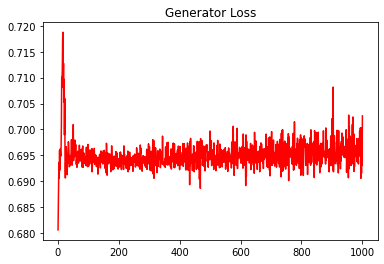

In [11]:
ABC_train_test2.training_GAN_skip_connection(disc3,gen3,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,0,device)

In [12]:
ABC_GAN3_metrics=ABC_train_test2.test_generator(gen3,test_data,prior_model,variance,0,"3",device)
sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

print("MSE")
print(mean(ABC_GAN3_metrics[0]))

MSE
0.005377218385311482


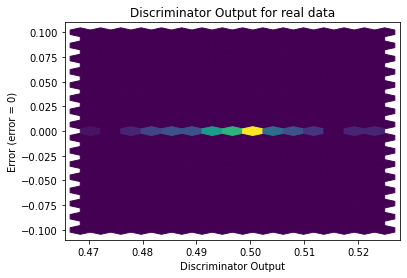

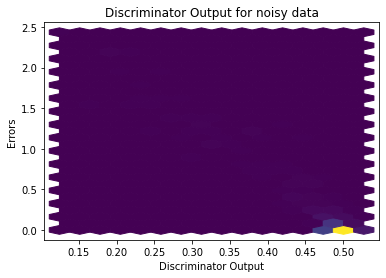

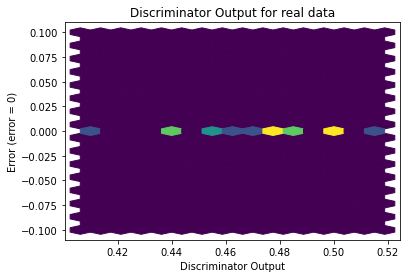

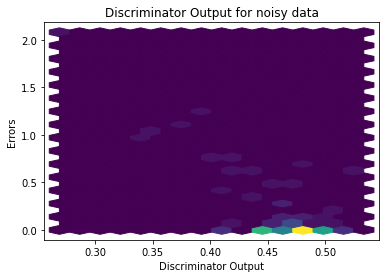

In [13]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [14]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.4590]], requires_grad=True)
